In [2]:
pip install yfinance

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 62.4 MB/s eta 0:00:00
  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15549 sha256=2efdb0e7f1e5fa56e2fb376979a6d20e2bbaa741e29ac04733a0181ba8962643
  Stored in directory: /home/jovyan/.

In [47]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 44.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 73.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/14 [tensorflow]4 [tensorflow]]data-server]
Note: you may need to restart the kernel to use updated packages.


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler  # <-- add this

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# LSTM (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras import layers, models

2025-12-06 22:21:17.411625: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-06 22:21:17.412130: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-06 22:21:17.472056: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/srv/conda/envs/notebook/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/fr

In [4]:
np.random.seed(42)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

In [9]:
def download_sp500(start_date: str = "1990-01-01", end_date: str = None, ticker: str = "^GSPC"):
    df = yf.download(ticker, start=start_date, end=end_date)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df.columns.name = None
    return df

In [10]:
def add_technical_indicators(df: pd.DataFrame):
    
    df = df.copy()

    # Simple moving averages
    df["MA10"] = df["Close"].rolling(window=10).mean()
    df["MA50"] = df["Close"].rolling(window=50).mean()

    # Exponential moving averages
    df["EMA10"] = df["Close"].ewm(span=10, adjust=False).mean()
    df["EMA50"] = df["Close"].ewm(span=50, adjust=False).mean()

    # Daily returns & log returns
    df["Return"] = df["Close"].pct_change()
    df["LogReturn"] = np.log1p(df["Return"])

    # Rolling volatility (e.g., 20-day std of returns)
    df["Volatility20"] = df["Return"].rolling(window=20).std()

    # Momentum: price difference vs 10 days ago
    df["Momentum10"] = df["Close"] - df["Close"].shift(10)

    # MACD (12-26 EMA) and signal line (9-period EMA of MACD)
    ema12 = df["Close"].ewm(span=12, adjust=False).mean()
    ema26 = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"] = ema12 - ema26
    df["MACD_signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

    return df

In [12]:
def make_supervised_frame(df: pd.DataFrame, target_col: str = "Return", horizon: int = 1, lags: int = 1):
    df = df.copy()

    # Target: horizon-h ahead
    df["y"] = df[target_col].shift(-horizon)

    # Lagged target(s)
    for lag in range(1, lags + 1):
        df[f"{target_col}_lag{lag}"] = df[target_col].shift(lag)

    # Drop rows with NaNs created by shifting
    df = df.dropna()

    return df

In [13]:
def time_series_split(df: pd.DataFrame, train_frac: float = 0.6, val_frac: float = 0.2):
   
    n = len(df)
    train_end = int(n * train_frac)
    val_end = int(n * (train_frac + val_frac))

    df_train = df.iloc[:train_end].copy()
    df_val = df.iloc[train_end:val_end].copy()
    df_test = df.iloc[val_end:].copy()

    return df_train, df_val, df_test

In [14]:
def compute_regression_metrics(y_true, y_pred):
    
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    r2 = r2_score(y_true, y_pred)

    return {"RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2}

In [16]:
def directional_accuracy(y_true, y_pred):
    
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    true_sign = np.sign(y_true)
    pred_sign = np.sign(y_pred)

    return np.mean(true_sign == pred_sign)

In [20]:
sp500 = download_sp500(start_date="1990-01-01")
sp500 = sp500[["Open", "High", "Low", "Close", "Volume"]].copy()
print(sp500.head())
print(sp500.tail())

/tmp/ipykernel_228/1157608011.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price             Open        High         Low       Close     Volume
Ticker           ^GSPC       ^GSPC       ^GSPC       ^GSPC      ^GSPC
Date                                                                 
1990-01-02  353.399994  359.690002  351.980011  359.690002  162070000
1990-01-03  359.690002  360.589996  357.890015  358.760010  192330000
1990-01-04  358.760010  358.760010  352.890015  355.670013  177000000
1990-01-05  355.670013  355.670013  351.350006  352.200012  158530000
1990-01-08  352.200012  354.239990  350.540009  353.790009  140110000
Price              Open         High          Low        Close      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2025-12-01  6812.299805  6843.649902  6799.939941  6812.629883  4549370000
2025-12-02  6830.959961  6851.549805  6806.709961  6829.370117  4582290000
2025-12-03  6815.290039  6862.419922  6810.430176  6849.720215  4

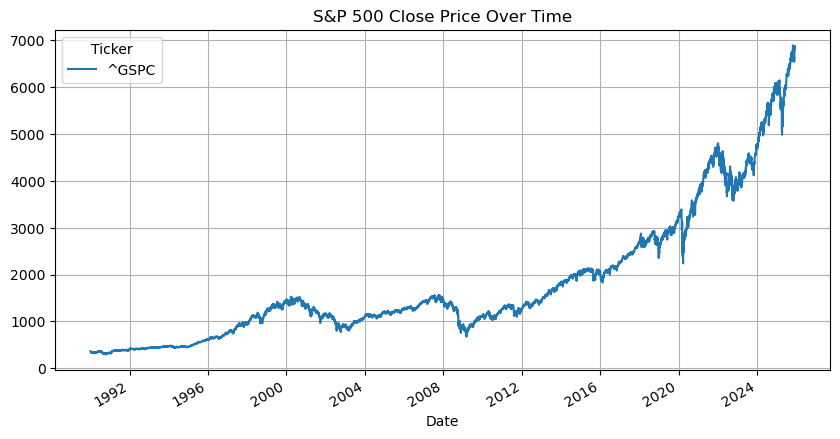

In [21]:
sp500["Close"].plot(title="S&P 500 Close Price Over Time")
plt.show()

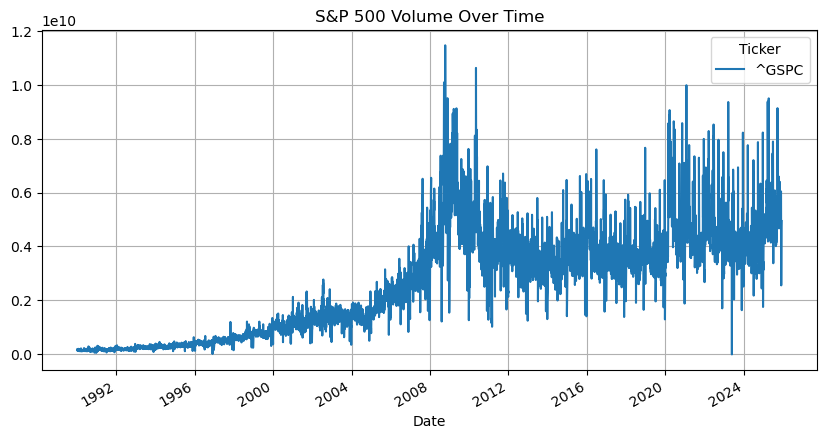

In [22]:
sp500["Volume"].plot(title="S&P 500 Volume Over Time")
plt.show()

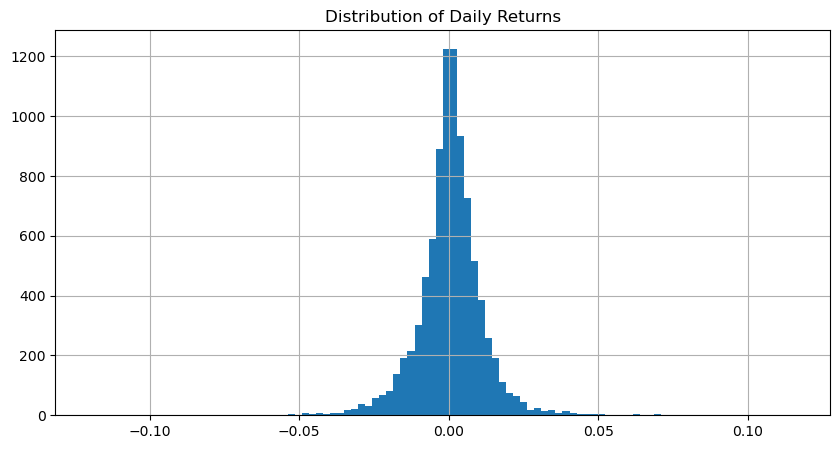

In [23]:
returns = sp500["Close"].pct_change()
returns.hist(bins=100)
plt.title("Distribution of Daily Returns")
plt.show()

In [24]:
print("Basic stats of daily returns:")
print(returns.describe())

Basic stats of daily returns:
Ticker        ^GSPC
count   9049.000000
mean       0.000391
std        0.011379
min       -0.119841
25%       -0.004430
50%        0.000603
75%        0.005711
max        0.115800


In [25]:
sp500_feat = add_technical_indicators(sp500)

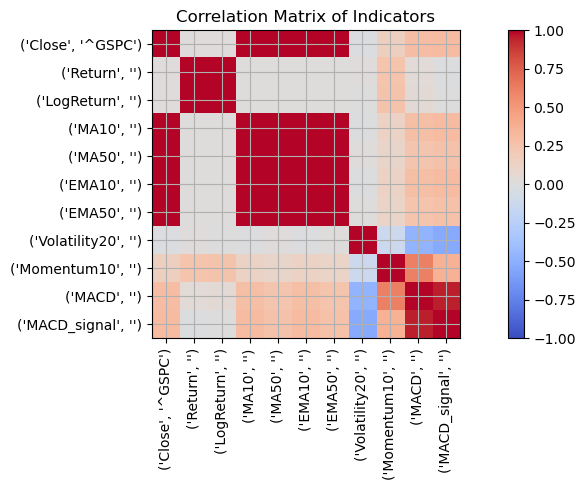

In [26]:
corr = sp500_feat[["Close", "Return", "LogReturn", "MA10", "MA50", "EMA10", "EMA50", "Volatility20", "Momentum10", "MACD", "MACD_signal"]].dropna().corr()

plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Matrix of Indicators")
plt.tight_layout()
plt.show()

In [27]:
df_sup = make_supervised_frame(sp500_feat, target_col="LogReturn", horizon=1, lags=3)

df_sup.head()

Price,Open,High,Low,Close,Volume,MA10,MA50,EMA10,EMA50,Return,LogReturn,Volatility20,Momentum10,MACD,MACD_signal,y,LogReturn_lag1,LogReturn_lag2,LogReturn_lag3
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,
1990-03-13,338.670013,338.670013,335.359985,336.000000,145440000,336.166000,335.755001,335.943020,337.536140,-0.007884,-0.007915,0.007626,5.739990,0.922821,-0.212164,0.002586,0.002187,-0.006901,0.009805
1990-03-14,336.000000,337.630005,334.929993,336.869995,145060000,336.663998,335.298601,336.111561,337.510017,0.002589,0.002586,0.007623,4.979980,0.965092,0.023287,0.003556,-0.007915,0.002187,-0.006901
1990-03-15,336.869995,338.910004,336.869995,338.070007,144410000,337.197000,334.884801,336.467642,337.531977,0.003562,0.003556,0.007632,5.330017,1.082940,0.235218,0.011295,0.002586,-0.007915,0.002187
1990-03-16,338.070007,341.910004,338.070007,341.910004,222520000,337.834000,334.609601,337.457163,337.703664,0.011359,0.011295,0.007797,6.369995,1.469254,0.482025,0.004727,0.003556,0.002586,-0.007915
1990-03-19,341.910004,343.760010,339.119995,343.529999,142300000,338.813000,334.436201,338.561315,337.932148,0.004738,0.004727,0.007628,9.790009,1.884409,0.762502,-0.005722,0.011295,0.003556,0.002586


In [28]:
df_train, df_val, df_test = time_series_split(df_sup, train_frac=0.6, val_frac=0.2)

feature_cols = [c for c in df_sup.columns if c not in ["y"]]

X_train, y_train = df_train[feature_cols], df_train["y"]
X_val, y_val = df_val[feature_cols], df_val["y"]
X_test, y_test = df_test[feature_cols], df_test["y"]

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

Train size: 5400
Val size: 1800
Test size: 1800


In [29]:
y_test_naive = df_test["LogReturn"]  

baseline_metrics = compute_regression_metrics(y_test, y_test_naive)
baseline_dir_acc = directional_accuracy(y_test, y_test_naive)

print("Naive baseline metrics:", baseline_metrics)
print("Naive baseline directional accuracy:", baseline_dir_acc)

Naive baseline metrics: {'RMSE': 0.019379820632977385, 'MAE': 0.012266523278311034, 'MAPE': 59089811.8114882, 'R2': -1.3105028360159858}
Naive baseline directional accuracy: 0.48944444444444446


In [30]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_val_lr = linreg.predict(X_val)
y_test_lr = linreg.predict(X_test)

lr_val_metrics = compute_regression_metrics(y_val, y_val_lr)
lr_test_metrics = compute_regression_metrics(y_test, y_test_lr)
lr_dir_acc = directional_accuracy(y_test, y_test_lr)

print("Linear Regression – validation metrics:", lr_val_metrics)
print("Linear Regression – test metrics:", lr_test_metrics)
print("Linear Regression – test directional accuracy:", lr_dir_acc)

Linear Regression – validation metrics: {'RMSE': 7.237836830494073e-08, 'MAE': 5.88313772241648e-08, 'MAPE': 269.74823945617413, 'R2': 0.9999999999285021}
Linear Regression – test metrics: {'RMSE': 1.9300615057079196e-07, 'MAE': 1.422440786853442e-07, 'MAPE': 629.7528509473359, 'R2': 0.9999999997708344}
Linear Regression – test directional accuracy: 1.0


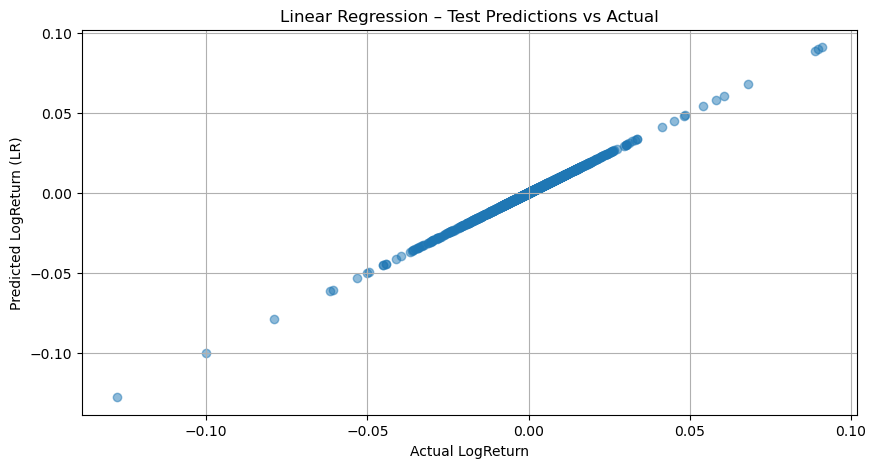

In [31]:
plt.scatter(y_test, y_test_lr, alpha=0.5)
plt.xlabel("Actual LogReturn")
plt.ylabel("Predicted LogReturn (LR)")
plt.title("Linear Regression – Test Predictions vs Actual")
plt.show()

In [34]:
rf = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42)
rf.fit(X_train, y_train)

y_val_rf = rf.predict(X_val)
y_test_rf = rf.predict(X_test)

rf_val_metrics = compute_regression_metrics(y_val, y_val_rf)
rf_test_metrics = compute_regression_metrics(y_test, y_test_rf)
rf_dir_acc = directional_accuracy(y_test, y_test_rf)

print("Random Forest – validation metrics:", rf_val_metrics)
print("Random Forest – test metrics:", rf_test_metrics)
print("Random Forest – test directional accuracy:", rf_dir_acc)

Random Forest – validation metrics: {'RMSE': 3.821007043960367e-05, 'MAE': 8.761852780379373e-06, 'MAPE': 48938.0125908423, 'R2': 0.9999800734837359}
Random Forest – test metrics: {'RMSE': 0.0011334460761750168, 'MAE': 7.841676801254832e-05, 'MAPE': 406826.537303675, 'R2': 0.9920966952924501}
Random Forest – test directional accuracy: 0.9994444444444445


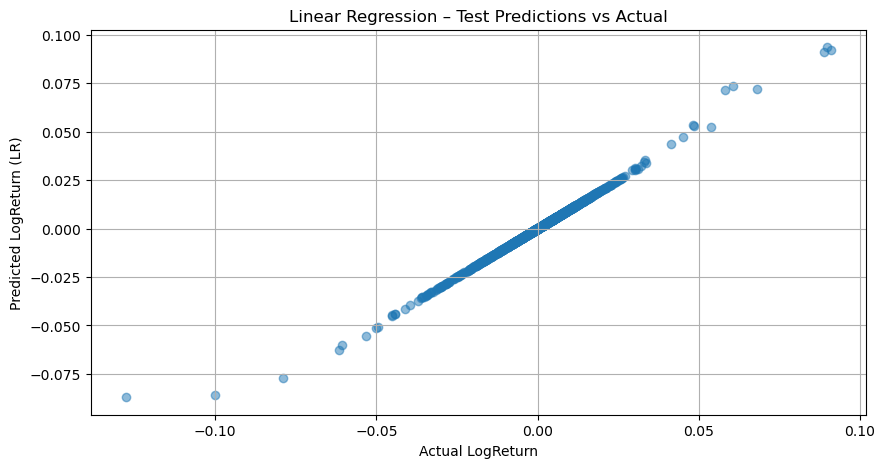

In [36]:
plt.scatter(y_test, y_test_rf, alpha=0.5)
plt.xlabel("Actual LogReturn")
plt.ylabel("Predicted LogReturn (LR)")
plt.title("Linear Regression – Test Predictions vs Actual")
plt.show()

/srv/conda/envs/notebook/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/srv/conda/envs/notebook/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/srv/conda/envs/notebook/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/srv/conda/envs/notebook/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

ARIMA metrics (val+test window): {'RMSE': 0.010910070813924146, 'MAE': 0.0071574719262859484, 'MAPE': 34446232.39246052, 'R2': -0.0003672625368145166}
ARIMA directional accuracy: 0.5458078845086063


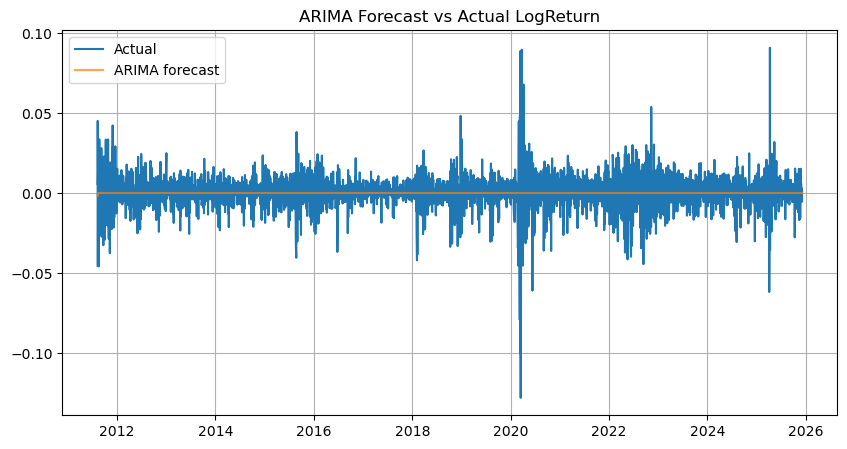

In [45]:
# 10. ARIMA baseline (simplified, univariate)


# We'll model LogReturn as a univariate series
logret_series = sp500_feat["LogReturn"].dropna()

# Align with df_sup range (so we're forecasting over the same overall period)
logret_aligned = logret_series.loc[df_sup.index]

train_end_idx = df_train.index[-1]
val_end_idx = df_val.index[-1]

logret_train = logret_aligned.loc[:train_end_idx]
logret_val = logret_aligned.loc[train_end_idx:val_end_idx]
logret_test = logret_aligned.loc[val_end_idx:]

# Fit a simple ARIMA(1,0,1) on the training portion
arima_model = ARIMA(logret_train, order=(1, 0, 1))
arima_result = arima_model.fit()

# Forecast over validation + test window
n_forecast = len(logret_val) + len(logret_test)
arima_forecast = arima_result.forecast(steps=n_forecast)

# Take the last n_forecast actual values to compare against
logret_val_test = logret_aligned.iloc[-n_forecast:]

# --- Clean and align for metrics (avoid NaNs) ---

# Put both into arrays
y_true = logret_val_test.to_numpy()
y_pred = np.asarray(arima_forecast)

# In case lengths differ for any reason, clip to the shorter one
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

# Drop any NaNs that might still be present
mask = (~np.isnan(y_true)) & (~np.isnan(y_pred))
y_true_clean = y_true[mask]
y_pred_clean = y_pred[mask]

# Compute metrics
arima_metrics = compute_regression_metrics(y_true_clean, y_pred_clean)
arima_dir_acc = directional_accuracy(y_true_clean, y_pred_clean)

print("ARIMA metrics (val+test window):", arima_metrics)
print("ARIMA directional accuracy:", arima_dir_acc)

# Plot actual vs forecast on the same time index
plot_index = logret_val_test.index[:len(y_true_clean)]
plt.plot(plot_index, y_true_clean, label="Actual")
plt.plot(plot_index, y_pred_clean, label="ARIMA forecast", alpha=0.7)
plt.legend()
plt.title("ARIMA Forecast vs Actual LogReturn")
plt.show()

In [49]:
tf.random.set_seed(42)

In [50]:
scaler = StandardScaler()
scaler.fit(X_train[feature_cols])

X_train_scaled = scaler.transform(X_train[feature_cols])
X_val_scaled   = scaler.transform(X_val[feature_cols])
X_test_scaled  = scaler.transform(X_test[feature_cols])

y_train_array = y_train.to_numpy()
y_val_array   = y_val.to_numpy()
y_test_array  = y_test.to_numpy()

In [51]:
def make_lstm_sequences(X_array, y_array, seq_len: int):
    
    X_seq, y_seq = [], []
    n_samples = len(X_array)

    for t in range(seq_len, n_samples):
        X_seq.append(X_array[t-seq_len:t])
        y_seq.append(y_array[t])

    return np.array(X_seq), np.array(y_seq)

In [52]:
SEQ_LEN = 30 

X_train_seq, y_train_seq=make_lstm_sequences(X_train_scaled, y_train_array, SEQ_LEN)
X_val_seq,   y_val_seq=make_lstm_sequences(X_val_scaled,   y_val_array,   SEQ_LEN)
X_test_seq,  y_test_seq=make_lstm_sequences(X_test_scaled,  y_test_array,  SEQ_LEN)

print("LSTM train sequence shape:", X_train_seq.shape, y_train_seq.shape)
print("LSTM val sequence shape:",   X_val_seq.shape,   y_val_seq.shape)
print("LSTM test sequence shape:",  X_test_seq.shape,  y_test_seq.shape)

LSTM train sequence shape: (5370, 30, 19) (5370,)
LSTM val sequence shape: (1770, 30, 19) (1770,)
LSTM test sequence shape: (1770, 30, 19) (1770,)


In [53]:
n_features = X_train_seq.shape[2]

lstm_model = models.Sequential([
    layers.Input(shape=(SEQ_LEN, n_features)),
    layers.LSTM(32, return_sequences=False),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mse")

lstm_model.summary()

2025-12-06 22:23:18.242538: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,201 (28.13 KB)

 Trainable params: 7,201 (28.13 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
history = lstm_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=15,           # you can adjust this
    batch_size=32,
    verbose=1
)

Epoch 1/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0018 - val_loss: 8.6958e-04
Epoch 2/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.1667e-04 - val_loss: 3.7323e-04
Epoch 3/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.2495e-04 - val_loss: 2.4274e-04
Epoch 4/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.9521e-04 - val_loss: 1.3672e-04
Epoch 5/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.7478e-04 - val_loss: 1.0279e-04
Epoch 6/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5659e-04 - val_loss: 9.7898e-05
Epoch 7/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4892e-04 - val_loss: 9.7659e-05
Epoch 8/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4173e-04 - val_loss: 9.6497e-05
Epoch 9/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.3757e-04 - val_loss: 1.0330e-04
Epoch 10/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.3340e-04 - val_loss: 1.1180e-04
Epoch 11/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

In [55]:
y_test_lstm = lstm_model.predict(X_test_seq).flatten()

lstm_test_metrics = compute_regression_metrics(y_test_seq, y_test_lstm)
lstm_dir_acc      = directional_accuracy(y_test_seq, y_test_lstm)

print("LSTM – test metrics:", lstm_test_metrics)
print("LSTM – test directional accuracy:", lstm_dir_acc)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LSTM – test metrics: {'RMSE': 0.034381754701168735, 'MAE': 0.024803760741816887, 'MAPE': 93017279.85476111, 'R2': -6.306046162582972}
LSTM – test directional accuracy: 0.4858757062146893


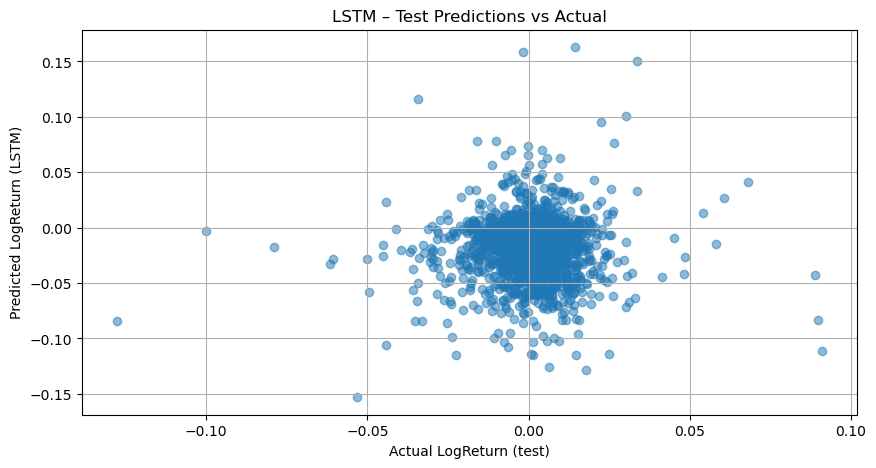

In [56]:
plt.scatter(y_test_seq, y_test_lstm, alpha=0.5)
plt.xlabel("Actual LogReturn (test)")
plt.ylabel("Predicted LogReturn (LSTM)")
plt.title("LSTM – Test Predictions vs Actual")
plt.show()

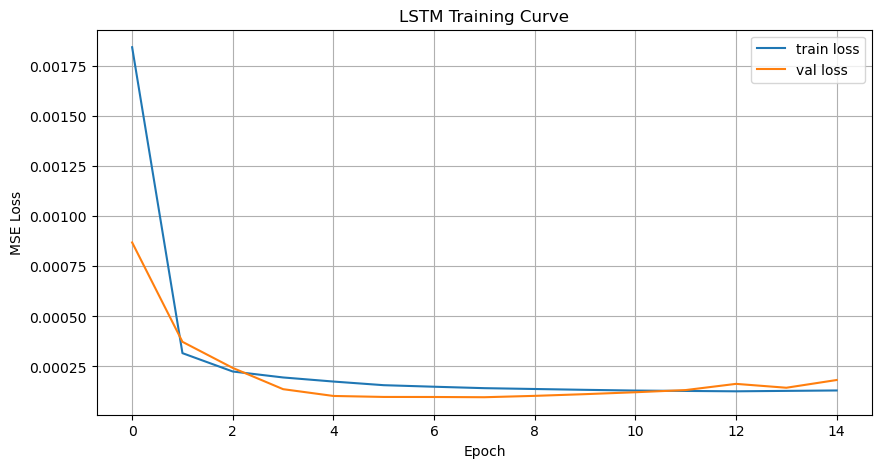

In [57]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("LSTM Training Curve")
plt.legend()
plt.show()

In [58]:
summary_rows = []

summary_rows.append(
    {"Model": "Naive",
     **baseline_metrics,
     "DirAcc": baseline_dir_acc}
)

summary_rows.append(
    {"Model": "LinearRegression",
     **lr_test_metrics,
     "DirAcc": lr_dir_acc}
)

summary_rows.append(
    {"Model": "RandomForest",
     **rf_test_metrics,
     "DirAcc": rf_dir_acc}
)

summary_rows.append(
    {"Model": "ARIMA(1,0,1)",
     **arima_metrics,
     "DirAcc": arima_dir_acc}
)

summary_rows.append(
    {"Model": "LSTM",
     **lstm_test_metrics,
     "DirAcc": lstm_dir_acc}
)

summary_df = pd.DataFrame(summary_rows)
summary_df

,Model,RMSE,MAE,MAPE,R2,DirAcc
0,Naive,1.937982e-02,1.226652e-02,5.908981e+07,-1.310503,0.489444
1,LinearRegression,1.930062e-07,1.422441e-07,6.297529e+02,1.000000,1.000000
2,RandomForest,1.133446e-03,7.841677e-05,4.068265e+05,0.992097,0.999444
3,"ARIMA(1,0,1)",1.091007e-02,7.157472e-03,3.444623e+07,-0.000367,0.545808
4,LSTM,3.438175e-02,2.480376e-02,9.301728e+07,-6.306046,0.485876


/tmp/ipykernel_228/2611804212.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(summary_df["Model"], rotation=45, ha="right")
/tmp/ipykernel_228/2611804212.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(summary_df["Model"], rotation=45, ha="right")


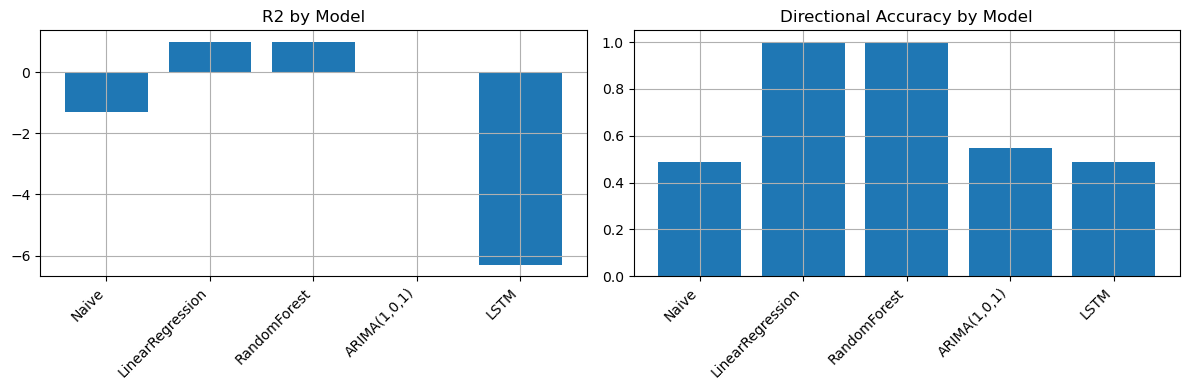

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(summary_df["Model"], summary_df["R2"])
axes[0].set_title("R2 by Model")
axes[0].set_xticklabels(summary_df["Model"], rotation=45, ha="right")

axes[1].bar(summary_df["Model"], summary_df["DirAcc"])
axes[1].set_title("Directional Accuracy by Model")
axes[1].set_xticklabels(summary_df["Model"], rotation=45, ha="right")

plt.tight_layout()
plt.show()